In [1]:
#1 Imports & Paths & Constants
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import os

from pathlib import Path
from functools import wraps
from libpysal.weights import Queen

## 1.1 Paths
DATA_DIR = Path("data")
RAW_DIR  = DATA_DIR / "raw"
GEO_DIR  = DATA_DIR / "geo"
TABLE_DIR = DATA_DIR / "table"

for d in [DATA_DIR, RAW_DIR, GEO_DIR, TABLE_DIR]:
    d.mkdir(parents=True, exist_ok=True)

## 1.2 ORCA Configs
CALENDAR_YMD = "20240614"
LISTINGS_YMD = "20250615"
CITY = "London"

HOST = "https://orca.casa.ucl.ac.uk"
ORCA_PATH = "~jreades/data"

CALENDAR_FILE = f"{CALENDAR_YMD}-{CITY}-calendar.csv.gz"
LISTINGS_FILE = f"{LISTINGS_YMD}-{CITY}-listings.csv.gz"

## 1.3 Thresholds / Constants
VIOLATION_THRESHOLD        = 90
COMMERCIAL_AVAIL_THRESHOLD = 60
HOTEL_LIKE_OCC_THRESHOLD   = 180

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [2]:
#2 Cache/Download Helpers & Download ORCA & Download Borough polygons
## 2.1 Cache
def check_cache(f):
    @wraps(f)
    def wrapper(src: str, dst_dir: Path, min_size: int = 1000) -> Path:
        fn = Path(src.split("?")[0]).name
        dst = dst_dir / fn
        if dst.is_file() and dst.stat().st_size > min_size:
            print(f"+ cached: {dst}")
            return dst
        print(f"+ downloading: {dst}")
        return f(src, dst)
    return wrapper

@check_cache
def cache_data(src: str, dst: Path) -> Path:
    dst.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(src)
    r.raise_for_status()
    dst.write_bytes(r.content)
    print("+ done")
    return dst.resolve()

## 2.2 Download ORCA Listing/Calendar
listings_url = f"{HOST}/{ORCA_PATH}/{LISTINGS_FILE}"
calendar_url = f"{HOST}/{ORCA_PATH}/{CALENDAR_FILE}"

listings_path = cache_data(listings_url, RAW_DIR)
calendar_path = cache_data(calendar_url, RAW_DIR)

## 2.3 Download Borough Polygons (gpkg)
borough_url = "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Boroughs.gpkg"
borough_path = GEO_DIR / "Boroughs.gpkg"
borough_path = cache_data(borough_url, GEO_DIR)

+ cached: data/raw/20250615-London-listings.csv.gz
+ cached: data/raw/20240614-London-calendar.csv.gz
+ cached: data/geo/Boroughs.gpkg


In [3]:
#3 Core Wrangling: read listings & stream calendar & merge & flags
CHUNK_SIZE = 200_000

def load_listings(path: Path) -> pd.DataFrame:
    cols_in_file = pd.read_csv(path, nrows=0).columns.tolist()

    desired_cols = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price",
    ]
    usecols = [c for c in desired_cols if c in cols_in_file]
    df = pd.read_csv(path, usecols=usecols, low_memory=False)

    # clean price if present
    if "price" in df.columns:
        price_str = df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
        df["price_clean"] = pd.to_numeric(price_str, errors="coerce")
    return df

def summarise_calendar_streaming(
    path: Path,
    chunk_size: int = CHUNK_SIZE,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-14",
) -> pd.DataFrame:
    agg = {}  # {listing_id: [occupied_nights, total_nights]}

    for chunk in pd.read_csv(
        path,
        chunksize=chunk_size,
        usecols=["listing_id", "available", "date"],
        low_memory=False
    ):
        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        chunk = chunk.dropna(subset=["date"])

        mask = (chunk["date"] >= start_date) & (chunk["date"] < end_date)
        chunk = chunk.loc[mask].copy()

        # InsideAirbnb: available = "t"/"f" sometimes; normalize
        av = chunk["available"].astype(str).str.lower()
        chunk["is_available"] = av.isin(["t", "true", "1", "yes"])

        for lid, g in chunk.groupby("listing_id"):
            total = len(g)
            occ = int((~g["is_available"]).sum())  # occupied nights
            if lid not in agg:
                agg[lid] = [0, 0]
            agg[lid][0] += occ
            agg[lid][1] += total

    summary = (
        pd.DataFrame.from_dict(agg, orient="index", columns=["occupied_nights", "total_nights"])
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )
    summary["available_nights"] = summary["total_nights"] - summary["occupied_nights"]
    summary["occupancy_rate"] = summary["occupied_nights"] / summary["total_nights"]
    return summary

def merge_calendar_listings(occ_summary: pd.DataFrame, listings: pd.DataFrame) -> pd.DataFrame:
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price_clean",
    ]
    existing_cols = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[existing_cols].drop_duplicates(subset="id"),
        left_on="listing_id",
        right_on="id",
        how="left",
    )
    return merged

def add_core_flags(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # entire home flag
    if "room_type" in out.columns:
        out["is_entire_home"] = out["room_type"].astype(str).str.contains("entire", case=False, na=False)
    else:
        out["is_entire_home"] = False

    # 90-day rule violation (entire homes only)
    out["violates_90day"] = (out["is_entire_home"]) & (out["occupied_nights"] > VIOLATION_THRESHOLD)

    # commercial STR (your logic: available nights > threshold)
    out["commercial_STR"] = (out["is_entire_home"]) & (out["available_nights"] > COMMERCIAL_AVAIL_THRESHOLD)

    # hotel-like (your logic: occupied nights > threshold)
    out["hotel_like_STR"] = (out["is_entire_home"]) & (out["occupied_nights"] > HOTEL_LIKE_OCC_THRESHOLD)

    return out

def prepare_merged(calendar_path: Path, listings_path: Path) -> pd.DataFrame:
    print("=== Loading calendar (streaming) ===")
    occ_summary = summarise_calendar_streaming(calendar_path)
    print("calendar summary:", occ_summary.shape)

    print("=== Loading listings ===")
    listings = load_listings(listings_path)
    print("listings:", listings.shape)

    print("=== Merging + flags ===")
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_core_flags(merged)

    print("merged:", merged.shape)
    return merged

merged = prepare_merged(calendar_path=calendar_path, listings_path=listings_path)
merged.head()

=== Loading calendar (streaming) ===
calendar summary: (93480, 5)
=== Loading listings ===
listings: (96651, 10)
=== Merging + flags ===
merged: (93480, 18)


,listing_id,occupied_nights,total_nights,available_nights,occupancy_rate,id,host_id,room_type,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,number_of_reviews,price_clean,is_entire_home,violates_90day,commercial_STR,hotel_like_STR
0,13913,34,364,330,0.093407,13913.0,54730.0,Private room,Islington,NaN,51.56861,-0.11270,54.0,72.0,False,False,False,False
1,15400,202,364,162,0.554945,15400.0,60302.0,Entire home/apt,Kensington and Chelsea,NaN,51.48780,-0.16813,97.0,120.0,True,True,True,True
2,17402,100,363,263,0.275482,17402.0,67564.0,Entire home/apt,Westminster,NaN,51.52195,-0.14094,56.0,510.0,True,True,True,False
3,24328,363,363,0,1.000000,24328.0,41759.0,Entire home/apt,Wandsworth,NaN,51.47072,-0.16266,94.0,213.0,True,True,False,True
4,33332,0,365,365,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


In [4]:
#4 Q1.1 Policy (90-day rule)
## 4.1 Function Definitions
def _unique_entire_listings(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["is_entire_home"]].drop_duplicates(subset="listing_id").copy()

def citywide_violation_stats(df: pd.DataFrame) -> dict:
    entire = _unique_entire_listings(df)
    total_entire = entire["listing_id"].nunique()

    n_viol = int(entire["violates_90day"].sum())
    share_viol = n_viol / total_entire if total_entire > 0 else np.nan

    return {
        "total_entire_homes": total_entire,
        "n_violations": n_viol,
        "share_violations": share_viol,
    }

def violation_by_neighbourhood(
    df: pd.DataFrame,
    borough_col: str = "neighbourhood_cleansed"
) -> pd.DataFrame:
    entire = _unique_entire_listings(df).dropna(subset=[borough_col]).copy()

    out = (
        entire.groupby(borough_col, as_index=False)
        .agg(
            n_entire=("listing_id", "nunique"),
            n_violations=("violates_90day", "sum"),
        )
    )
    out["share_violations"] = out["n_violations"] / out["n_entire"]
    out = out.rename(columns={borough_col: "borough"})
    return out

def plot_occupied_nights_hist(df: pd.DataFrame) -> None:
    entire = _unique_entire_listings(df)
    x = entire["occupied_nights"].dropna()

    plt.figure()
    plt.hist(x, bins=50)
    plt.axvline(VIOLATION_THRESHOLD, linestyle="--")
    plt.xlabel("Occupied nights (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Figure-1 Distribution of Occupied Nights (Entire Homes)")
    plt.tight_layout()
    plt.show()

def plot_top_violation_areas(neigh_stats: pd.DataFrame, top_n: int = 20) -> None:
    df = neigh_stats.sort_values("share_violations", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["share_violations"])
    plt.gca().invert_yaxis()
    plt.xlabel("Share of entire homes violating 90-day rule")
    plt.title(f"Figure-2 Top {top_n} Areas by Violation Share")
    plt.tight_layout()
    plt.show()

def commercial_by_neighbourhood(df: pd.DataFrame) -> pd.DataFrame:
    d = (
        df[df["is_entire_home"]]
        .drop_duplicates(subset="listing_id")
        .copy()
    )

    out = (
        d.groupby("neighbourhood_cleansed", as_index=False)
        .agg(
            n_entire=("listing_id", "nunique"),
            n_commercial=("commercial_STR", "sum"),
        )
    )
    out["commercial_share"] = out["n_commercial"] / out["n_entire"]
    out = out.rename(columns={"neighbourhood_cleansed": "borough"})
    return out
    
def build_neighbourhood_policy_commercial_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a borough-level table with:
      - share_violations (90-day rule)
      - commercial_share (commercial STR)
    """
    neigh_policy = violation_by_neighbourhood(df)         # borough + share_violations
    neigh_comm   = commercial_by_neighbourhood(df)        # borough + commercial_share

    neigh_stats = (
        neigh_policy
        .merge(neigh_comm[["borough", "commercial_share"]], on="borough", how="inner")
        .dropna(subset=["share_violations", "commercial_share"])
    )
    return neigh_stats
    
def plot_share_commercial_vs_violations(neigh_stats: pd.DataFrame) -> None:
    df = neigh_stats.dropna(subset=["share_violations", "commercial_share", "borough"]).copy()
    if df.empty:
        print("No valid boroughs for Figure 3, skipping plot.")
        return

    df["borough_label"] = df["borough"].astype(str).str.strip().str.title()

    plt.figure(figsize=(10, 6))

    plt.scatter(df["share_violations"], df["commercial_share"], s=60, alpha=0.8)
    
    dx, dy = 0.002, 0.002
    for _, r in df.iterrows():
        plt.text(
            r["share_violations"] + dx,
            r["commercial_share"] + dy,
            r["borough_label"],
            fontsize=9
        )
    plt.xlabel("Share of 90-day violations (entire homes)")
    plt.ylabel("Share of commercial STR (entire homes)")
    plt.title("Figure-3 Commercial STR vs 90-day Violations by Borough")
    plt.tight_layout()
    plt.show()

=== Citywide 90-day rule stats ===
{'total_entire_homes': 40112, 'n_violations': 33375, 'share_violations': 0.8320452732349422}


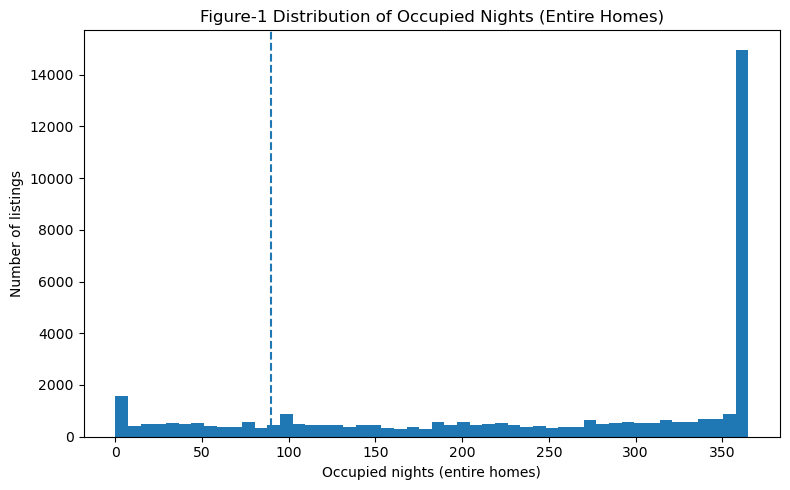

In [5]:
## 4.2 Citywide 90-day rule stats + Figure 1 (toggleable)
RUN_CITYWIDE = True  

if RUN_CITYWIDE:
    city = citywide_violation_stats(merged)

    print("=== Citywide 90-day rule stats ===")
    print(city)

    # Figure 1
    plot_occupied_nights_hist(merged)


=== Neighbourhood (borough) violation table (top 10 by share) ===
                   borough  n_entire  n_violations  share_violations
21                 Lambeth      2131          1891          0.887377
11                 Hackney      3019          2654          0.879099
27               Southwark      2195          1928          0.878360
18               Islington      2440          2122          0.869672
22                Lewisham      1041           904          0.868396
13                Haringey       961           826          0.859521
12  Hammersmith and Fulham      1880          1612          0.857447
31              Wandsworth      2148          1832          0.852886
30          Waltham Forest       779           659          0.845956
26    Richmond upon Thames       637           537          0.843014


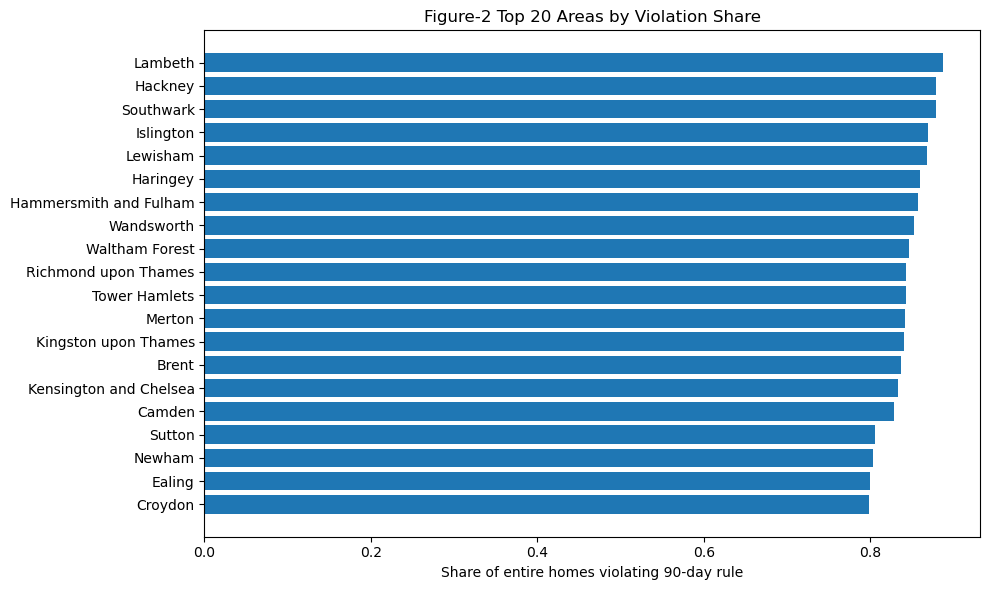

In [6]:
## 4.3 Neighbourhood (borough) table + Figure 2 (toggleable)
RUN_NEIGH = True           
SHOW_NEIGH_TABLE = True   
SHOW_NEIGH_PLOT  = True   

TOP_N = 20

if RUN_NEIGH:
    neigh = violation_by_neighbourhood(merged)

    print("\n=== Neighbourhood (borough) violation table (top 10 by share) ===")
    print(neigh.sort_values("share_violations", ascending=False).head(10))

    # Figure 2
    plot_top_violation_areas(neigh, top_n=TOP_N)


=== Policy Figure 3: Commercial STR vs 90-day violations ===


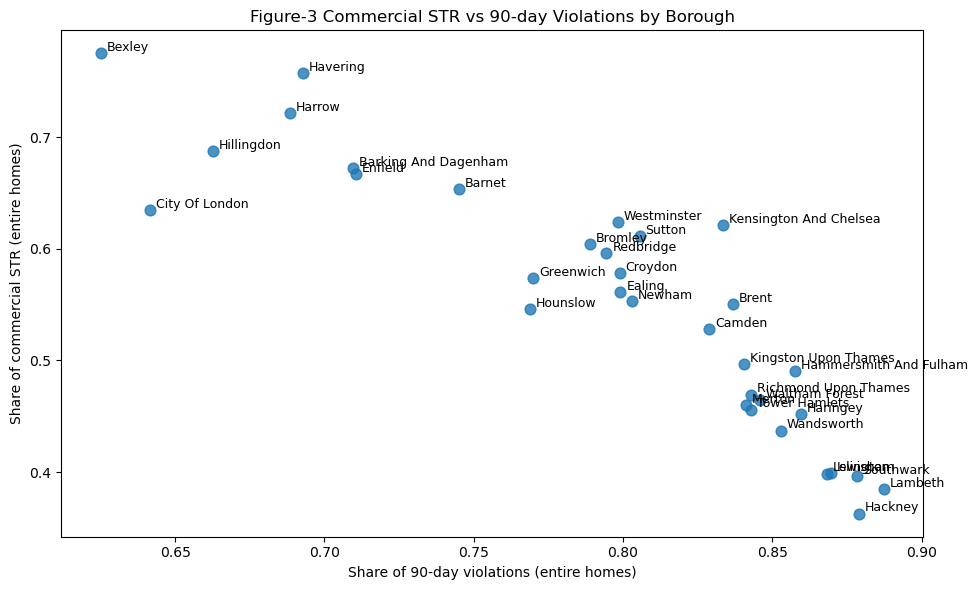

In [7]:
# 4.4 Policy Figure 3: Commercial STR vs 90-day violations (toggleable)
RUN_FIG3 = True
SHOW_FIG3_PLOT = True

if RUN_FIG3:
    neigh_stats = build_neighbourhood_policy_commercial_stats(merged)

    if SHOW_FIG3_PLOT:
        print("\n=== Policy Figure 3: Commercial STR vs 90-day violations ===")
        plot_share_commercial_vs_violations(neigh_stats)

In [8]:
#5 Q1.2 Commercialisation
## 5.1 Function Definitions
def _unique_listings(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop_duplicates(subset="listing_id").copy()

def compute_entire_home_stats(df: pd.DataFrame) -> dict:
    d = _unique_listings(df)

    total_listings = d["listing_id"].nunique()
    entire = d[d["is_entire_home"]]
    n_entire = entire["listing_id"].nunique()
    share_entire = n_entire / total_listings if total_listings > 0 else np.nan

    n_commercial = int(entire["commercial_STR"].sum())
    share_commercial = n_commercial / n_entire if n_entire > 0 else np.nan

    n_hotel_like = int(entire["hotel_like_STR"].sum())
    share_hotel_like = n_hotel_like / n_entire if n_entire > 0 else np.nan

    n_legal_but_commercial = int(
        ((~entire["violates_90day"]) & (entire["commercial_STR"])).sum()
    )
    share_legal_but_comm = n_legal_but_commercial / n_entire if n_entire > 0 else np.nan

    return {
        "total_listings": total_listings,
        "n_entire": n_entire,
        "share_entire": share_entire,
        "n_commercial_entire": n_commercial,
        "share_commercial_entire": share_commercial,
        "n_hotel_like_entire": n_hotel_like,
        "share_hotel_like_entire": share_hotel_like,
        "n_legal_but_commercial_entire": n_legal_but_commercial,
        "share_legal_but_commercial_entire": share_legal_but_comm,
    }

def host_structure(df: pd.DataFrame) -> dict:
    d = _unique_listings(df)
    host_counts = d.groupby("host_id")["listing_id"].nunique()
    return {"host_counts": host_counts}

def plot_host_distribution(host_structure_stats: dict, max_listings: int = 12) -> None:
    host_counts: pd.Series = host_structure_stats["host_counts"]
    vc = host_counts.value_counts().sort_index()
    vc = vc[vc.index <= max_listings]

    plt.figure(figsize=(8, 5))
    plt.bar(vc.index.astype(int), vc.values)
    plt.xlabel("Listings per host")
    plt.ylabel("Number of hosts")
    plt.title("Figure-4 Host Distribution (Capped)")
    plt.tight_layout()
    plt.show()

def plot_commercial_composition(stats: dict) -> None:
    labels = [
        "Commercial STR",
        "Hotel-like STR",
        "Legal but commercial",
    ]
    values = [
        stats["share_commercial_entire"],
        stats["share_hotel_like_entire"],
        stats["share_legal_but_commercial_entire"],
    ]

    plt.figure(figsize=(7, 4))
    plt.bar(labels, values)
    plt.ylabel("Share of entire-home listings")
    plt.ylim(0, 1)
    plt.title("Figure-5 Commercialisation Composition (Entire Homes)")
    plt.tight_layout()
    plt.show()

In [9]:
## 5.2 Compute Stats Only
RUN_COMMERCIAL = True
SHOW_COMM_STATS = False

if RUN_COMMERCIAL:
    stats = compute_entire_home_stats(merged)
    hosts = host_structure(merged)

    if SHOW_COMM_STATS:
        print("=== Commercialisation summary (entire homes) ===")
        for k, v in stats.items():
            print(f"{k}: {v}")

    results_commercial = {
        "stats": stats,
        "hosts": hosts
    }

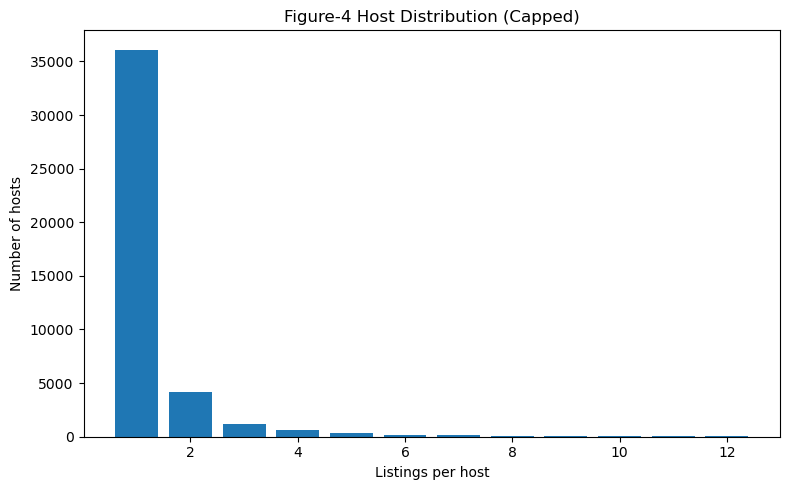

In [10]:
## 5.3 Commercialisation Figure 1: Host distribution
SHOW_HOST_PLOT = True   

if SHOW_HOST_PLOT:
    plot_host_distribution(results_commercial["hosts"])

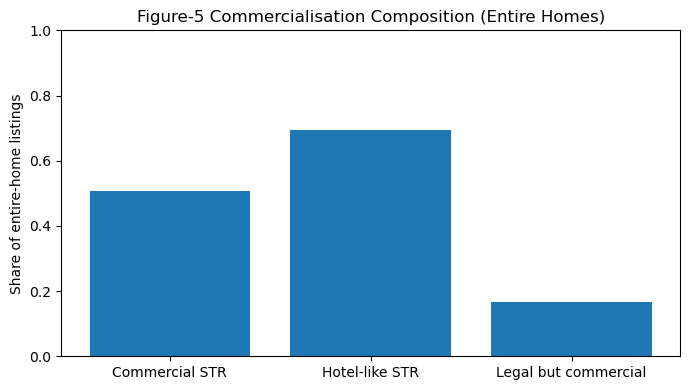

In [11]:
## 5.4 Commercialisation Figure 2: Commercial composition
SHOW_COMM_COMP_PLOT = True   

if SHOW_COMM_COMP_PLOT:
    plot_commercial_composition(results_commercial["stats"])

In [12]:
#6 Spatial Join & Build Borough-level Tables 
## 6.1 Read Brough Polygons 
boros = gpd.read_file(borough_path)
boros["borough"] = boros["NAME"].astype(str).str.strip().str.lower()

## 6.2 Points + Spatial join (new object; boros unchanged)
pts = gpd.GeoDataFrame(
    merged.copy(),
    geometry=gpd.points_from_xy(merged["longitude"], merged["latitude"]),
    crs="EPSG:4326"
).to_crs(boros.crs)

pts_boro = (
    gpd.sjoin(pts, boros[["borough", "geometry"]], how="left", predicate="within")
    .dropna(subset=["borough"])
    .copy()
)

## 6.3 Spatial Map 1: STR density per 1000 dwellings 
STOCK_CSV_PATH = TABLE_DIR / "social-landlord-housing-stock-borough.csv"
stock = pd.read_csv(STOCK_CSV_PATH)

housing = stock.copy()
housing["borough"] = housing["Area"].astype(str).str.strip().str.lower()

dwell_col = "Number of self-contained units or bedspaces-2024"
housing["dwellings"] = (
    housing[dwell_col].astype(str).str.replace(",", "", regex=False)
)
housing["dwellings"] = pd.to_numeric(housing["dwellings"], errors="coerce")
housing = housing[["borough", "dwellings"]]

borough_density = (
    pts_boro.groupby("borough", as_index=False)
    .agg(n_listings=("listing_id", "nunique"))
)
density_df = borough_density.merge(housing, on="borough", how="left")
density_df["str_density_per_1000"] = density_df["n_listings"] / density_df["dwellings"] * 1000

boros_density = boros.merge(density_df[["borough", "str_density_per_1000"]], on="borough", how="left")

## 6.4 Spatial Map 2: Commercial STR share
pts_boro["commercial_STR"] = pts_boro["commercial_STR"].astype(bool)

borough_comm = (
    pts_boro.groupby("borough", as_index=False)
    .agg(
        n_total=("listing_id", "nunique"),
        n_commercial=("commercial_STR", "sum"),
    )
)
borough_comm["commercial_share"] = borough_comm["n_commercial"] / borough_comm["n_total"]

boros_comm = boros.merge(borough_comm[["borough", "commercial_share"]], on="borough", how="left")

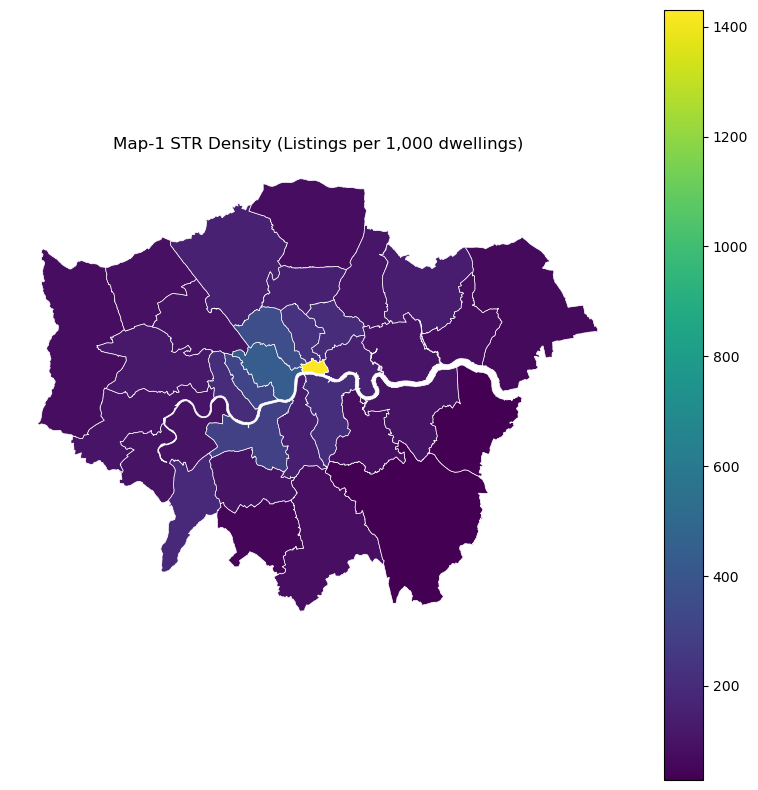

In [13]:
## 6.5 Spatial Map 1: STR density per 1,000 dwellings
SHOW_MAP_STR_DENSITY = True

if SHOW_MAP_STR_DENSITY:
    ax = boros_density.plot(
        column="str_density_per_1000",
        legend=True,
        figsize=(8, 8),
        edgecolor="white",
        linewidth=0.5,
        missing_kwds={
            "color": "lightgrey",
            "label": "No data"
        },
    )
    ax.set_axis_off()
    ax.set_title("Map-1 STR Density (Listings per 1,000 dwellings)")
    plt.tight_layout()
    plt.show()

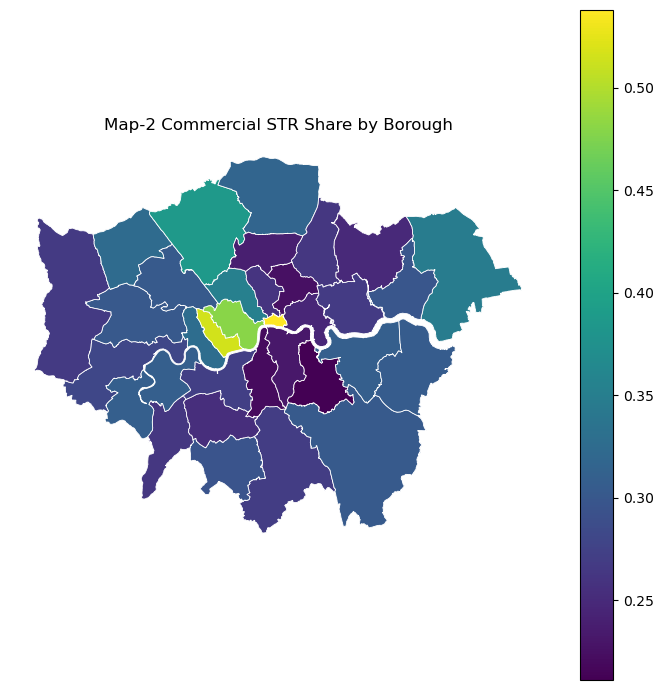

In [14]:
## 6.6 Spatial Map 2: Commercial STR share by borough
SHOW_MAP_COMMERCIAL = True

if SHOW_MAP_COMMERCIAL:
    ax = boros_comm.plot(
        column="commercial_share",
        legend=True,
        linewidth=0.6,
        edgecolor="white",
        figsize=(7, 7),
    )
    ax.set_title("Map-2 Commercial STR Share by Borough")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [15]:
#7 Spatial Autocorrelation (Global Moran + Moran scatter + Local Moran LISA map)
## 7.1 Defination & Compute
# Use the borough-level STR density surface (boros_density) for autocorrelation
gdf = boros_density[["geometry", "str_density_per_1000"]].dropna().reset_index(drop=True)

y = gdf["str_density_per_1000"].to_numpy(dtype=float)
z = (y - y.mean()) / y.std(ddof=1)

# Queen contiguity weights (Practical 7 style)
w = Queen.from_dataframe(gdf, use_index=False)
w.transform = "R"

n = len(z)
S0 = w.s0
Wz = w.sparse @ z

# Global Moran's I
I_obs = (n / S0) * (z @ Wz) / (z @ z)
print(f"Global Moran's I (observed): {I_obs:.4f}")

# Permutation test
perms = 999
rng = np.random.default_rng(42)
I_perm = np.empty(perms)

for p in range(perms):
    z_perm = rng.permutation(z)
    Wz_perm = w.sparse @ z_perm
    I_perm[p] = (n / S0) * (z_perm @ Wz_perm) / (z_perm @ z_perm)

p_two = (np.sum(np.abs(I_perm) >= np.abs(I_obs)) + 1) / (perms + 1)
print(f"Permutation p-value (two-sided, {perms} perms): {p_two:.4f}")

# Local Moran's I (LISA) without esda 
# prerequisites: gdf, z, w (Queen, row-standardised), lag_z already computed as Wz

alpha = 0.05
perms = 999
seed = 42

rng = np.random.default_rng(seed)

# spatial lag (row-standardised)
lag_z = w.sparse @ z

# observed local Moran statistic (common simple form)
Ii_obs = z * lag_z

# precompute neighbor list + weights
neighbors = w.neighbors
weights = w.weights

p_local = np.ones(len(z), dtype=float)

# GLOBAL permutation: shuffle entire z each time (less conservative than neighbor-only)
# For each i, build distribution of Ii_perm = z_i * sum_j w_ij z_perm_j
for i in range(len(z)):
    neigh = neighbors[i]
    if len(neigh) == 0:
        p_local[i] = 1.0
        continue

    w_i = np.asarray(weights[i], dtype=float)
    z_i = z[i]

    sims = np.empty(perms, dtype=float)
    for p in range(perms):
        z_perm = rng.permutation(z)                 # shuffle ALL areas
        sims[p] = z_i * np.sum(w_i * z_perm[neigh]) # keep i fixed, permute others

    # two-sided p-value (more strict)
    p_local[i] = (np.sum(sims >= Ii_obs[i]) + 1) / (perms + 1)

# store results
gdf_lisa = gdf.copy()
gdf_lisa["z"] = z
gdf_lisa["lag_z"] = lag_z
gdf_lisa["p"] = p_local

def lisa_quad(z_i, lag_i, p_i, alpha=0.05):
    if p_i > alpha:
        return "Not significant"
    if z_i > 0 and lag_i > 0:
        return "High-High"
    if z_i < 0 and lag_i < 0:
        return "Low-Low"
    if z_i > 0 and lag_i < 0:
        return "High-Low"
    if z_i < 0 and lag_i > 0:
        return "Low-High"
    return "Not significant"

gdf_lisa["cluster"] = [
    lisa_quad(gdf_lisa.loc[i, "z"], gdf_lisa.loc[i, "lag_z"], gdf_lisa.loc[i, "p"], alpha=alpha)
    for i in range(len(gdf_lisa))
]

print(gdf_lisa["cluster"].value_counts())

Global Moran's I (observed): 0.2037
Permutation p-value (two-sided, 999 perms): 0.0030
cluster
Not significant    27
Low-Low             3
High-High           3
Name: count, dtype: int64


In [16]:
## 7.2 Global Moran's I: Moran scatterplot
SHOW_MORAN_SCATTER = False

# Moran scatterplot
if SHOW_MORAN_SCATTER:
    plt.figure(figsize=(6, 6))
    plt.scatter(z, lag_z, s=25)
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)

    b = np.polyfit(z, lag_z, 1)[0]  # slope ~ Moran's I
    xs = np.array([z.min(), z.max()])
    plt.plot(xs, b * xs)

    plt.xlabel("z (STR density)")
    plt.ylabel("Spatial lag of z (Wz)")
    plt.title(f"Moran scatterplot (slope≈I={I_obs:.3f})")
    plt.tight_layout()
    plt.show()

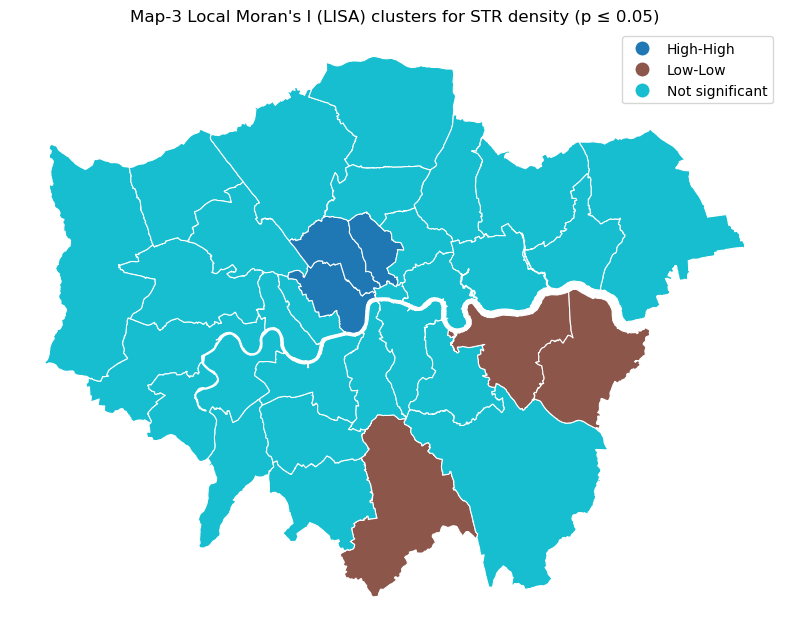

In [17]:
## 7.3 Local Moran's I: LISA Cluster Map
SHOW_LISA_MAP = True

if SHOW_LISA_MAP:
    ax = gdf_lisa.plot(
        column="cluster",
        categorical=True,
        legend=True,
        edgecolor="white",
        linewidth=0.8,
        figsize=(8, 8),
    )
    ax.set_title(f"Map-3 Local Moran's I (LISA) clusters for STR density (p ≤ {alpha})")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()